In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

from sklearn.metrics import  classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

In [3]:
import importlib
import ids_common
importlib.reload(ids_common)

SEED = random.randint(0, 42424242)
SEED = 42
print(f'SEED = {SEED}')

SEED = 42


In [4]:
df_orig = pd.read_csv('./sampled_data/sample_1/clean_ml_sample_balanced_2_class.csv', low_memory=False)
df_orig.shape

(240446, 61)

In [5]:
df_orig['Attack_label'].value_counts()

Attack_label
1    120223
0    120223
Name: count, dtype: int64

<Axes: xlabel='Attack_label'>

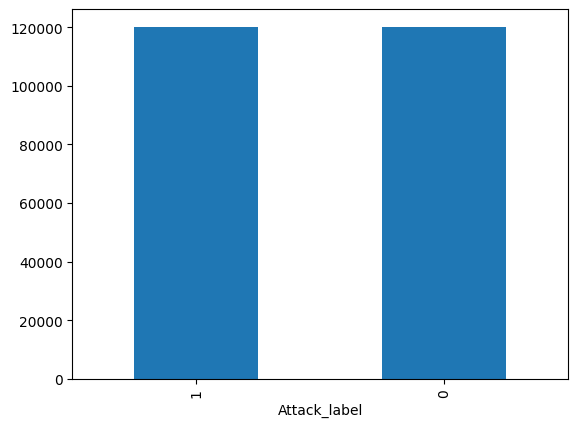

In [6]:
# Figure [traffic distribution]: Class distribution with respect to 'Attack_label'
df_orig['Attack_label'].value_counts().plot.bar()

<Axes: xlabel='Attack_type'>

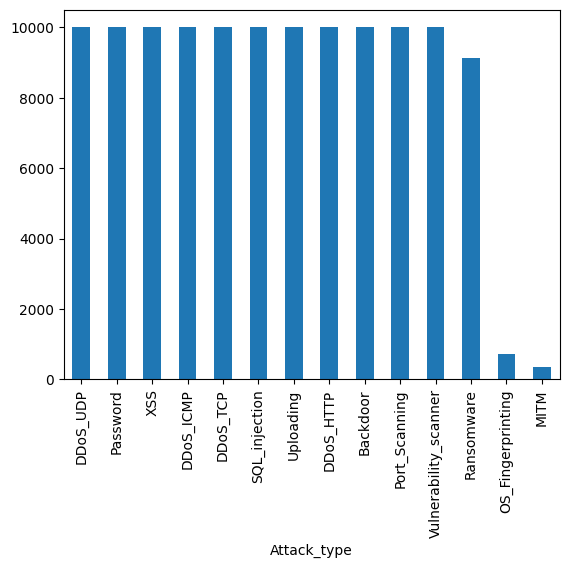

In [7]:
# Figure [attack distribution]: Class distribution with respect to 'Attack_type'
df_orig[df_orig['Attack_label']==1]['Attack_type'].value_counts().plot.bar()

In [8]:
df = df_orig

df_train, df_test = ids_common.ds_split(df, seed=42)

dataset = {}
dataset['2_class'] = {
    'train': ids_common.make_2_class(df_train),
    'test': ids_common.make_2_class(df_test)
}

dataset['14_class'] = {
    'train':ids_common.make_14_class(df_train),
    'test':ids_common.make_14_class(df_test)
}

dataset['15_class'] = {
    'train':ids_common.make_15_class(df_train),
    'test':ids_common.make_15_class(df_test)
}


def get_data(class_type, set_type):
    X, y = dataset[class_type][set_type]
    return X, y


def make_classifier(name, cls):
    X_train, y_train = get_data(name, 'train')
    X_test, y_test = get_data(name, 'test')

    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

    cls.fit(X_train, y_train)

    y_train_predict = cls.predict(X_train)
    y_test_predict = cls.predict(X_test)

    print(f'{cls.__class__.__name__}:')
    print(f'Train score: {cls.score(X_train, y_train)}')
    print(f'Test score:  {cls.score(X_test, y_test)}')

    ids_common.report(y_train, y_train_predict, y_test, y_test_predict, le)
    ids_common.plot_cm(y_test, y_test_predict, name=cls.__class__.__name__, le=le)
     
    return cls, le

DecisionTreeClassifier:
Train score: 0.9661668988750026
Test score:  0.9648367644000831
TRAIN:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     96178
           1       1.00      0.93      0.96     96178

    accuracy                           0.97    192356
   macro avg       0.97      0.97      0.97    192356
weighted avg       0.97      0.97      0.97    192356

TEST:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     24045
           1       1.00      0.93      0.96     24045

    accuracy                           0.96     48090
   macro avg       0.97      0.96      0.96     48090
weighted avg       0.97      0.96      0.96     48090



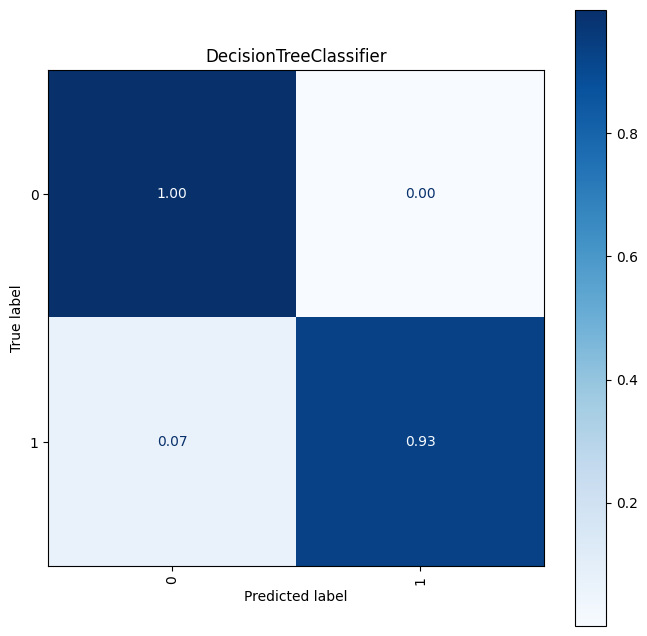

LogisticRegression:
Train score: 0.5845723554243174
Test score:  0.5851112497400707
TRAIN:
              precision    recall  f1-score   support

           0       0.57      0.71      0.63     96178
           1       0.61      0.46      0.53     96178

    accuracy                           0.58    192356
   macro avg       0.59      0.58      0.58    192356
weighted avg       0.59      0.58      0.58    192356

TEST:
              precision    recall  f1-score   support

           0       0.57      0.71      0.63     24045
           1       0.61      0.46      0.53     24045

    accuracy                           0.59     48090
   macro avg       0.59      0.59      0.58     48090
weighted avg       0.59      0.59      0.58     48090



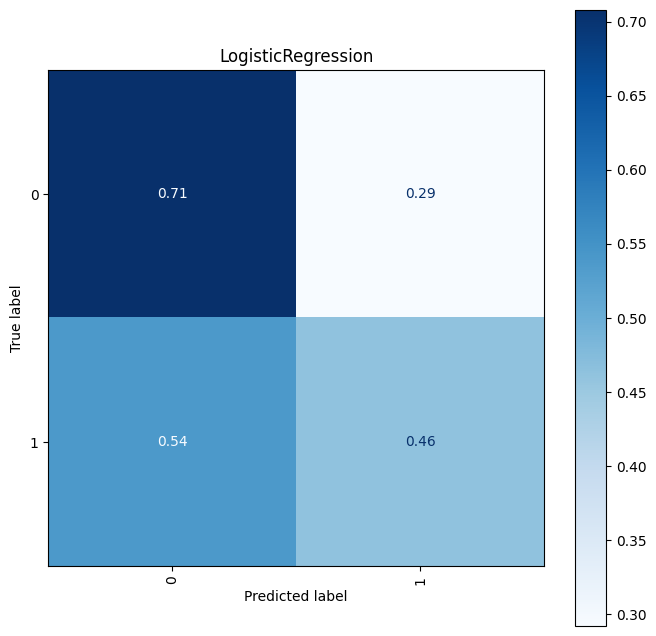

In [9]:

class_2_dt, le_2 = make_classifier( 
        '2_class',
        DecisionTreeClassifier(
                **{'criterion': 'entropy', 'max_depth': 8}, random_state=SEED),
)

class_2_lr, le_2 = make_classifier( 
        '2_class',
        LogisticRegression(
        **{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}, max_iter=10000, random_state=SEED)
)

DecisionTreeClassifier: [0.965, 0.967, 0.965, 0.965]
LogisticRegression: [0.585, 0.591, 0.585, 0.579]


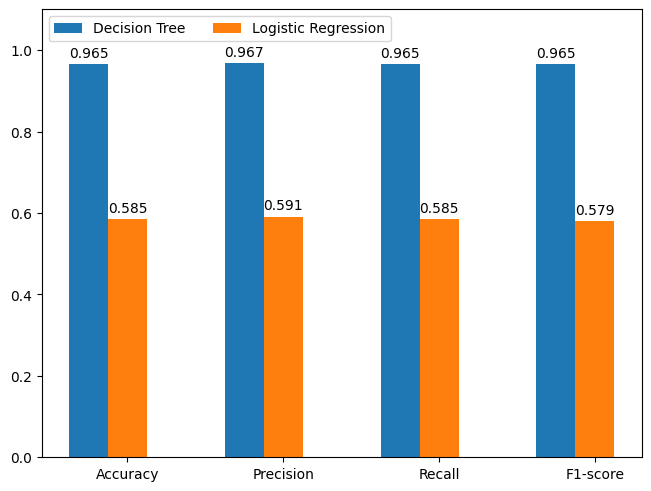

In [10]:
# Figure [detection dt lr]: Detection performance results.

X_test, y_test = get_data('2_class', 'test')
class_2_dt_report = classification_report(y_test, class_2_dt.predict(X_test), output_dict=True)
class_2_dt_report

dt = [class_2_dt_report['accuracy'], 
      class_2_dt_report['macro avg']['precision'], 
      class_2_dt_report['macro avg']['recall'], 
      class_2_dt_report['macro avg']['f1-score']
      ]

class_2_lr_report = classification_report(y_test, class_2_lr.predict(X_test), output_dict=True)

lr = [class_2_lr_report['accuracy'], 
      class_2_lr_report['macro avg']['precision'], 
      class_2_lr_report['macro avg']['recall'], 
      class_2_lr_report['macro avg']['f1-score']
      ]

dt = list(map(lambda x: round(x, 3), dt))
lr = list(map(lambda x: round(x, 3), lr))

print(f'{class_2_dt.__class__.__name__}: {dt}')
print(f'{class_2_lr.__class__.__name__}: {lr}')

reports = {
    'Decision Tree': dt,
    'Logistic Regression': lr,
}

labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in reports.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Length (mm)')
# ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.1)

plt.show()

RandomForestClassifier:
Train score: 0.9978685354239015
Test score:  0.9181534622582658
TRAIN:
                       precision    recall  f1-score   support

             Backdoor       1.00      1.00      1.00      8000
            DDoS_HTTP       1.00      1.00      1.00      8000
            DDoS_ICMP       1.00      1.00      1.00      8000
             DDoS_TCP       1.00      1.00      1.00      8000
             DDoS_UDP       1.00      1.00      1.00      8000
                 MITM       1.00      1.00      1.00       286
    OS_Fingerprinting       1.00      0.97      0.98       579
             Password       1.00      1.00      1.00      8000
        Port_Scanning       0.98      1.00      0.99      8000
           Ransomware       1.00      1.00      1.00      7313
        SQL_injection       1.00      1.00      1.00      8000
            Uploading       1.00      0.99      0.99      8000
Vulnerability_scanner       1.00      1.00      1.00      8000
                  XSS 

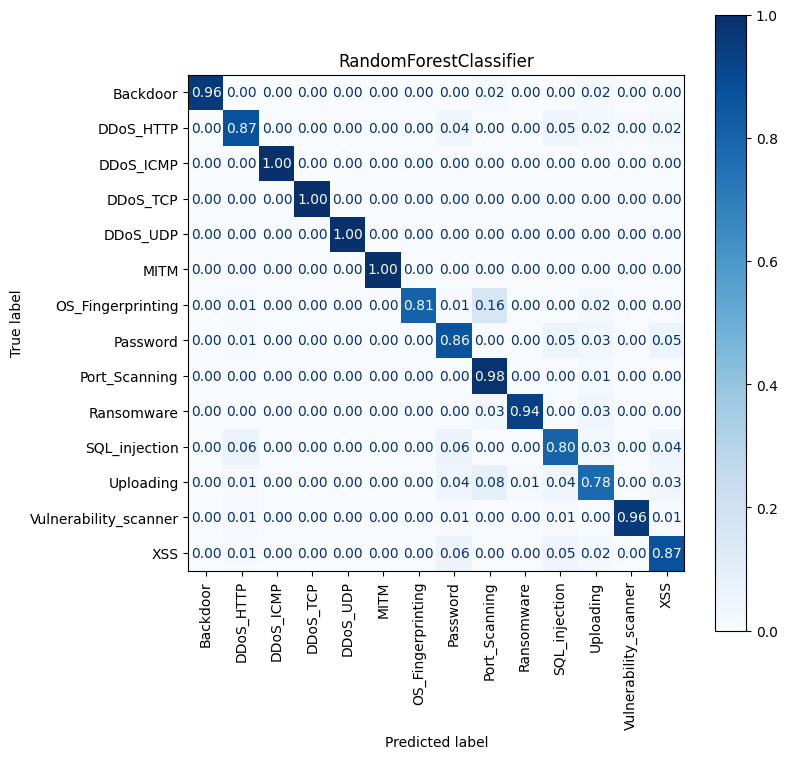

In [11]:
class_14_rf, le_14 = make_classifier( 
        '14_class',
        RandomForestClassifier(
        **{'criterion': 'entropy', 'max_depth': 32, 'max_features': 'log2', 'n_estimators': 100},random_state=SEED)
)

XGBClassifier:
Train score: 0.9500197550375346
Test score:  0.9229361613641089
TRAIN:
                       precision    recall  f1-score   support

             Backdoor       1.00      0.97      0.98      8000
            DDoS_HTTP       0.95      0.94      0.94      8000
            DDoS_ICMP       1.00      1.00      1.00      8000
             DDoS_TCP       1.00      1.00      1.00      8000
             DDoS_UDP       1.00      1.00      1.00      8000
                 MITM       1.00      1.00      1.00       286
    OS_Fingerprinting       1.00      0.82      0.90       579
             Password       0.85      0.95      0.90      8000
        Port_Scanning       0.87      1.00      0.93      8000
           Ransomware       1.00      0.94      0.97      7313
        SQL_injection       0.88      0.91      0.90      8000
            Uploading       0.94      0.81      0.87      8000
Vulnerability_scanner       1.00      0.97      0.99      8000
                  XSS       0.9

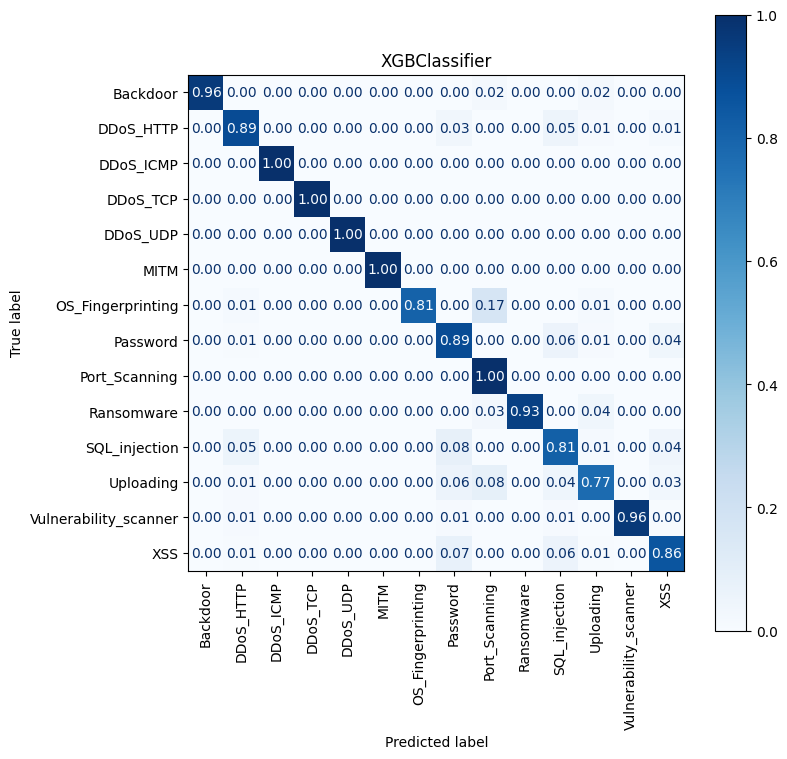

In [12]:
class_14_xgb, le_14 = make_classifier( 
        '14_class',
        xgb.XGBClassifier(objective="multi:softprob", random_state=SEED)
)

DecisionTreeClassifier: [0.918, 0.929, 0.917, 0.922]
XGBClassifier: [0.923, 0.936, 0.921, 0.927]


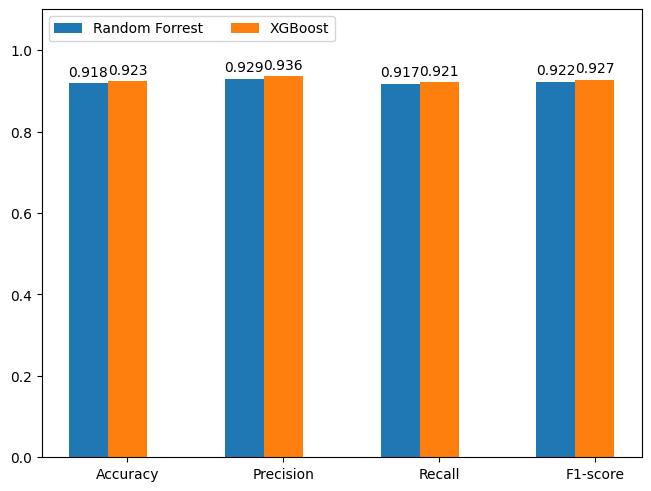

In [13]:
# Figure  [classification rf xgb 14 class] : Classification performance results.

X_test, y_test = get_data('14_class', 'test')
class_14_rf_report = classification_report(y_test, le_14.inverse_transform(class_14_rf.predict(X_test)), output_dict=True)

dt = [class_14_rf_report['accuracy'], 
      class_14_rf_report['macro avg']['precision'], 
      class_14_rf_report['macro avg']['recall'], 
      class_14_rf_report['macro avg']['f1-score']
      ]

class_14_xgb_report = classification_report(y_test, le_14.inverse_transform(class_14_xgb.predict(X_test)), output_dict=True)

lr = [class_14_xgb_report['accuracy'], 
      class_14_xgb_report['macro avg']['precision'], 
      class_14_xgb_report['macro avg']['recall'], 
      class_14_xgb_report['macro avg']['f1-score']
      ]

dt = list(map(lambda x: round(x, 3), dt))
lr = list(map(lambda x: round(x, 3), lr))

print(f'{class_2_dt.__class__.__name__}: {dt}')
print(f'{class_14_xgb.__class__.__name__}: {lr}')

reports = {
    'Random Forrest': dt,
    'XGBoost': lr,
}

labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in reports.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Length (mm)')
# ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.1)

plt.show()

RandomForestClassifier:
Train score: 0.9826779512986338
Test score:  0.9487835308796008
TRAIN:
                       precision    recall  f1-score   support

             Backdoor       1.00      1.00      1.00      8000
            DDoS_HTTP       1.00      0.98      0.99      8000
            DDoS_ICMP       1.00      1.00      1.00      8000
             DDoS_TCP       1.00      1.00      1.00      8000
             DDoS_UDP       1.00      1.00      1.00      8000
                 MITM       1.00      1.00      1.00       286
               Normal       0.97      1.00      0.98     96178
    OS_Fingerprinting       1.00      0.96      0.98       579
             Password       1.00      0.90      0.95      8000
        Port_Scanning       0.97      1.00      0.98      8000
           Ransomware       1.00      0.99      1.00      7313
        SQL_injection       1.00      0.90      0.95      8000
            Uploading       1.00      0.91      0.95      8000
Vulnerability_scanner 

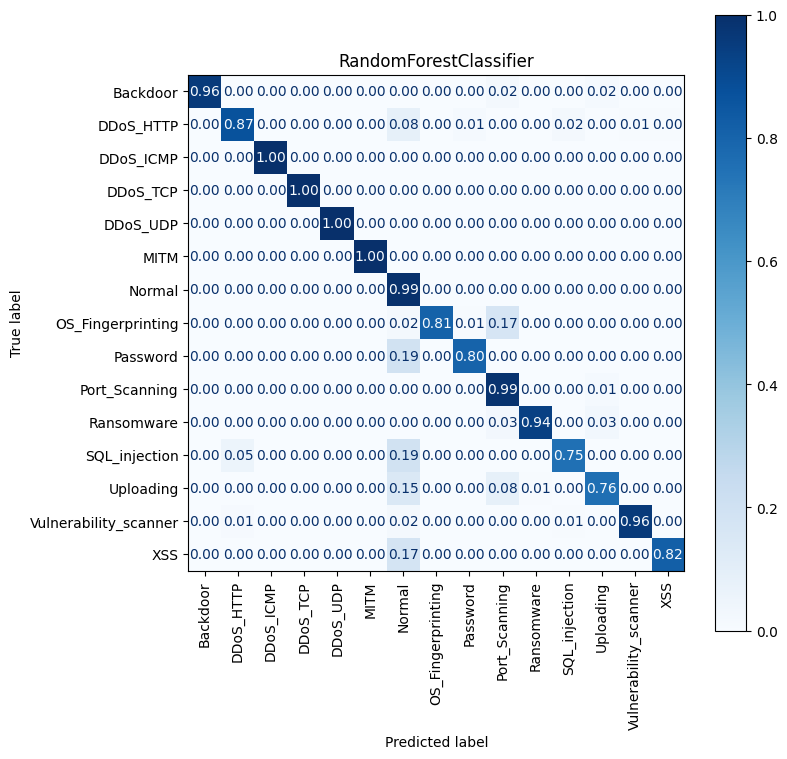

XGBClassifier:
Train score: 0.9566948782465845
Test score:  0.9526096901642753
TRAIN:
                       precision    recall  f1-score   support

             Backdoor       1.00      0.97      0.98      8000
            DDoS_HTTP       0.97      0.92      0.94      8000
            DDoS_ICMP       1.00      1.00      1.00      8000
             DDoS_TCP       1.00      1.00      1.00      8000
             DDoS_UDP       1.00      1.00      1.00      8000
                 MITM       1.00      1.00      1.00       286
               Normal       0.94      1.00      0.97     96178
    OS_Fingerprinting       1.00      0.83      0.91       579
             Password       1.00      0.80      0.89      8000
        Port_Scanning       0.87      1.00      0.93      8000
           Ransomware       1.00      0.94      0.97      7313
        SQL_injection       0.98      0.78      0.87      8000
            Uploading       0.95      0.77      0.85      8000
Vulnerability_scanner       1.0

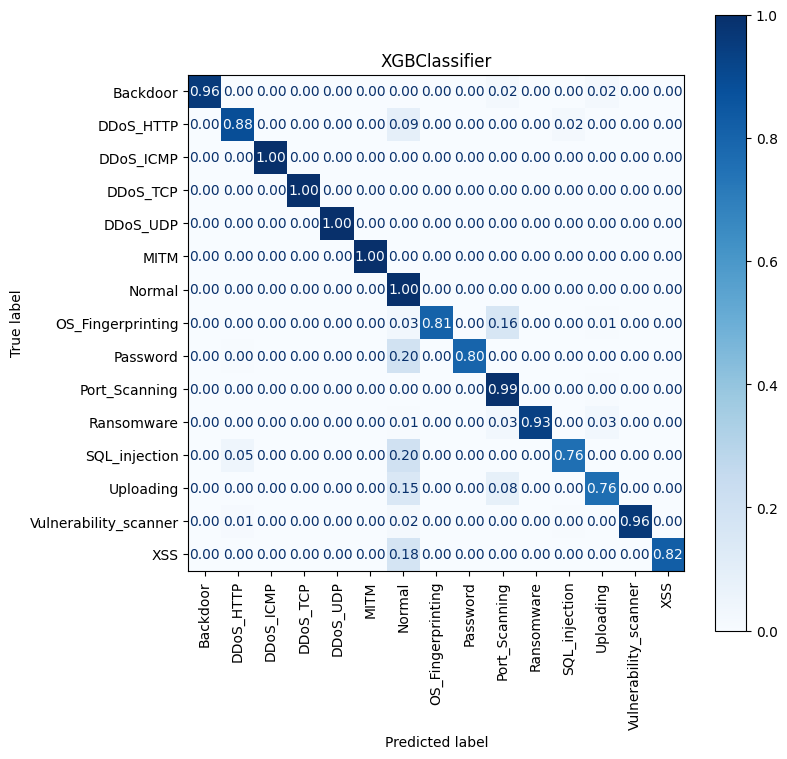

In [14]:
class_15_rf, le_15 = make_classifier( 
        '15_class',
        RandomForestClassifier(
        **{'criterion': 'entropy', 'max_depth': 32, 'max_features': 'log2', 'n_estimators': 100},random_state=SEED)
)

class_15_xgb, le_15 = make_classifier( 
        '15_class',
        xgb.XGBClassifier(objective="multi:softprob", random_state=SEED)
)

DecisionTreeClassifier: [0.949, 0.964, 0.909, 0.934]
XGBClassifier: [0.953, 0.974, 0.912, 0.939]


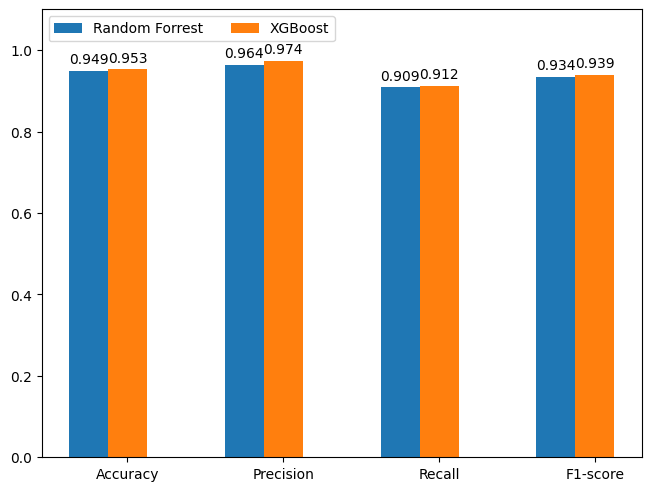

In [15]:
# Figure [classification rf xgb]: Classification performance results.

X_test, y_test = get_data('15_class', 'test')
class_15_rf_report = classification_report(y_test, le_15.inverse_transform(class_15_rf.predict(X_test)), output_dict=True)

dt = [class_15_rf_report['accuracy'], 
      class_15_rf_report['macro avg']['precision'], 
      class_15_rf_report['macro avg']['recall'], 
      class_15_rf_report['macro avg']['f1-score']
      ]

class_15_xgb_report = classification_report(y_test, le_15.inverse_transform(class_15_xgb.predict(X_test)), output_dict=True)

lr = [class_15_xgb_report['accuracy'], 
      class_15_xgb_report['macro avg']['precision'], 
      class_15_xgb_report['macro avg']['recall'], 
      class_15_xgb_report['macro avg']['f1-score']
      ]

dt = list(map(lambda x: round(x, 3), dt))
lr = list(map(lambda x: round(x, 3), lr))

print(f'{class_2_dt.__class__.__name__}: {dt}')
print(f'{class_14_xgb.__class__.__name__}: {lr}')

reports = {
    'Random Forrest': dt,
    'XGBoost': lr,
}

labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in reports.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Length (mm)')
# ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.1)

plt.show()

In [16]:
def eval_cascade(detector, classifier):

    _, y_class_2_test = get_data('2_class', 'test')
    X_test, y_class_15_test = get_data('15_class', 'test')

    # y_class_2_test = df_test[ids_common.target_label_2_class]
    # y_class_15_test = df_test[ids_common.target_label_15_class]

    # X_test = df_test.drop([ids_common.target_label_2_class, 
    #                 ids_common.target_label_15_class], 
    #                 axis=1, inplace=False)

    t_prediction = 0
    t = time.time()
    y_class_2_predict = detector.predict(X_test)
    t_prediction += time.time()-t


    ds_class_14 = df_test[y_class_2_predict==1]
    X_class_14 = ds_class_14.drop(
                    [ids_common.target_label_2_class, 
                    ids_common.target_label_15_class], 
                    axis=1, inplace=False)

    t = time.time()
    y_class_14_predict = classifier.predict(X_class_14)
    t_prediction += time.time()-t

    y_class_15_predict = pd.Series(y_class_2_predict, index=X_test.index.copy())
    y_class_15_predict = y_class_15_predict.map(lambda x: 'Normal' if x==0 else 'Attack')
    y_class_15_predict.loc[X_class_14.index] = le_14.inverse_transform(y_class_14_predict)

    print('DETECTION:')
    print(classification_report(y_class_2_test, y_class_2_predict))
    ids_common.plot_cm(y_class_2_test, y_class_2_predict)

    print('CLASSIFICATION:')
    print(classification_report(y_class_15_test, y_class_15_predict))
    ids_common.plot_cm(y_class_15_test, y_class_15_predict)

    print(f'prediction time {detector.__class__.__name__}+{classifier.__class__.__name__}: {t_prediction}')

    return y_class_15_predict

DETECTION:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     24045
           1       1.00      0.93      0.96     24045

    accuracy                           0.96     48090
   macro avg       0.97      0.96      0.96     48090
weighted avg       0.97      0.96      0.96     48090



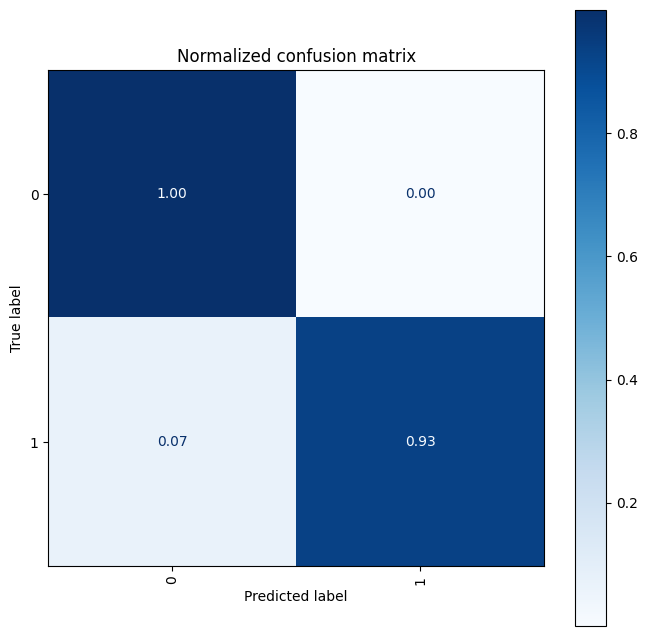

CLASSIFICATION:
                       precision    recall  f1-score   support

             Backdoor       1.00      0.96      0.98      2000
            DDoS_HTTP       0.93      0.86      0.89      2000
            DDoS_ICMP       1.00      1.00      1.00      2000
             DDoS_TCP       1.00      1.00      1.00      2000
             DDoS_UDP       1.00      1.00      1.00      2000
                 MITM       1.00      1.00      1.00        72
               Normal       0.93      1.00      0.97     24045
    OS_Fingerprinting       0.98      0.81      0.89       145
             Password       0.98      0.80      0.88      2000
        Port_Scanning       0.88      0.98      0.93      2000
           Ransomware       0.99      0.94      0.96      1828
        SQL_injection       0.96      0.75      0.84      2000
            Uploading       0.93      0.75      0.83      2000
Vulnerability_scanner       0.99      0.96      0.98      2000
                  XSS       0.99      

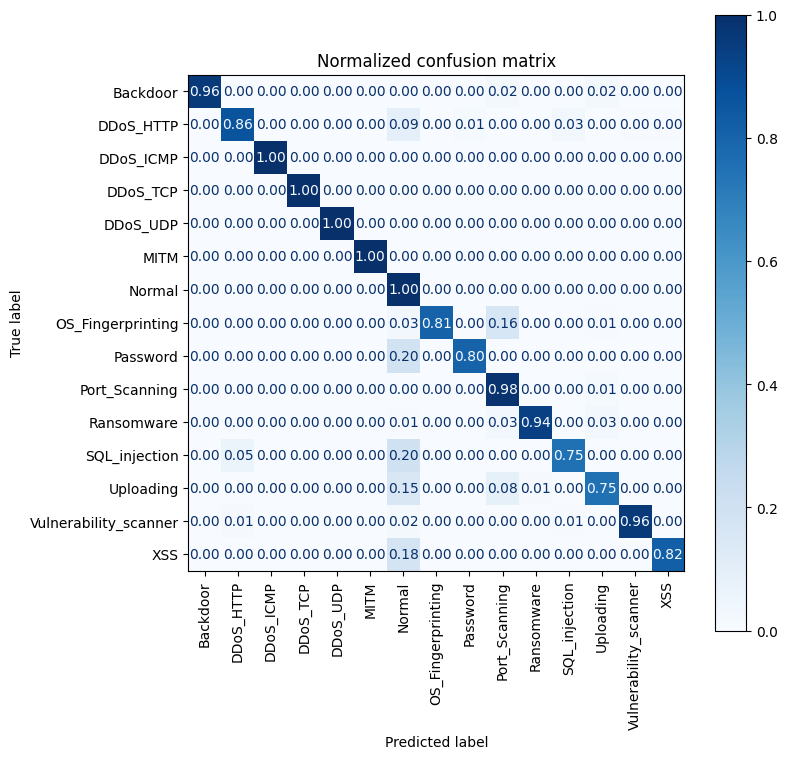

prediction time DecisionTreeClassifier+RandomForestClassifier: 0.31749391555786133


In [17]:
y_class_15_dt_rf = eval_cascade(class_2_dt, class_14_rf)

DETECTION:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     24045
           1       1.00      0.93      0.96     24045

    accuracy                           0.96     48090
   macro avg       0.97      0.96      0.96     48090
weighted avg       0.97      0.96      0.96     48090



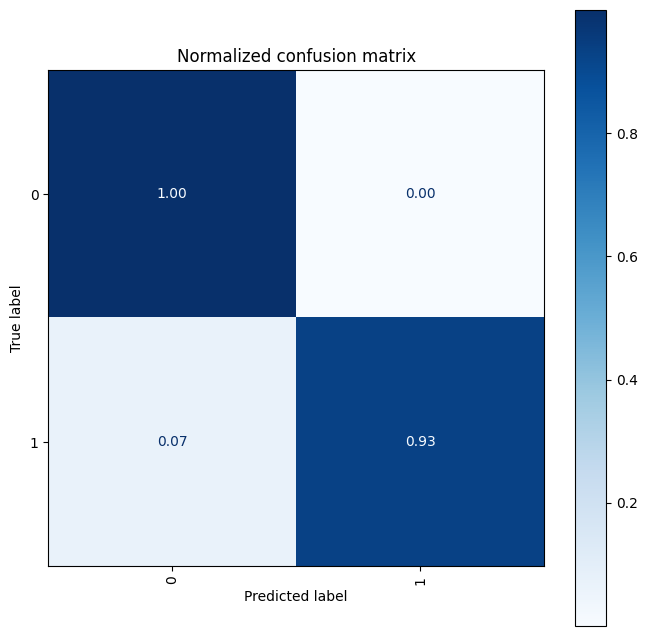

CLASSIFICATION:
                       precision    recall  f1-score   support

             Backdoor       1.00      0.96      0.98      2000
            DDoS_HTTP       0.94      0.88      0.91      2000
            DDoS_ICMP       1.00      1.00      1.00      2000
             DDoS_TCP       1.00      1.00      1.00      2000
             DDoS_UDP       1.00      1.00      1.00      2000
                 MITM       1.00      1.00      1.00        72
               Normal       0.93      1.00      0.97     24045
    OS_Fingerprinting       0.99      0.81      0.89       145
             Password       1.00      0.80      0.89      2000
        Port_Scanning       0.88      1.00      0.93      2000
           Ransomware       1.00      0.93      0.96      1828
        SQL_injection       0.96      0.76      0.84      2000
            Uploading       0.94      0.76      0.84      2000
Vulnerability_scanner       0.99      0.96      0.98      2000
                  XSS       1.00      

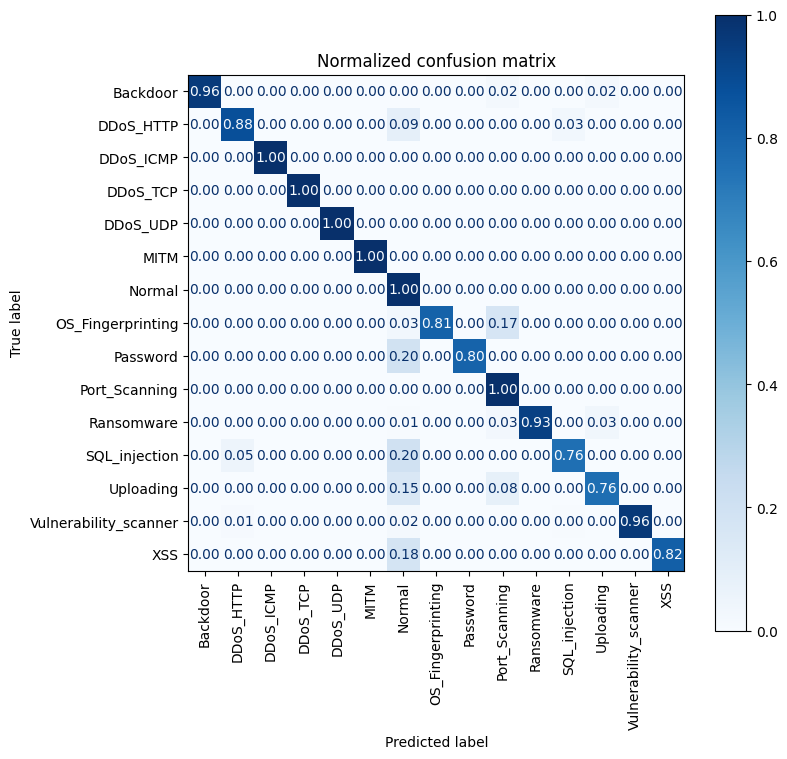

prediction time DecisionTreeClassifier+XGBClassifier: 0.10402321815490723


In [18]:
y_class_15_dt_xgb = eval_cascade(class_2_dt, class_14_xgb)

prediction time RandomForestClassifier: 0.6763820648193359
prediction time XGBClassifier: 0.17601609230041504
Method Accuracy Precision Recall F1-score
Random Forrest (15-class) 0.949 0.964 0.909 0.934
XGBoost (15-class) 0.953 0.974 0.912 0.939
DT-RF (15-class) 0.951 0.97 0.909 0.936
DT-XGB (15-class) 0.952 0.975 0.912 0.939


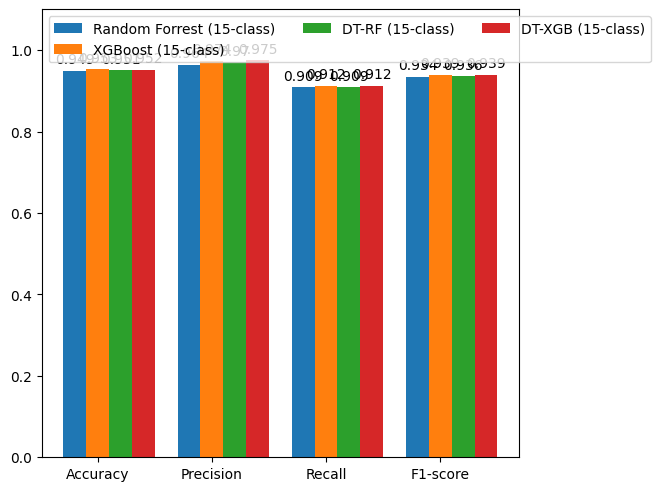

In [19]:
# Figure [classification rf xgb]: Classification performance results.

X_test, y_test = get_data('15_class', 'test')

t = time.time()
y_pred = class_15_rf.predict(X_test)
print(f'prediction time {class_15_rf.__class__.__name__}: {time.time()-t}')

class_15_rf_report = classification_report(y_test, le_15.inverse_transform(y_pred), output_dict=True)

t = time.time()
y_pred = class_15_xgb.predict(X_test)
print(f'prediction time {class_15_xgb.__class__.__name__}: {time.time()-t}')

class_15_xgb_report = classification_report(y_test, le_15.inverse_transform(y_pred), output_dict=True)

class_ids_dt_rf_report = classification_report(y_test, y_class_15_dt_rf, output_dict=True)
class_ids_dt_xgb_report = classification_report(y_test, y_class_15_dt_xgb, output_dict=True)

rf_15 = [class_15_rf_report['accuracy'], 
      class_15_rf_report['macro avg']['precision'], 
      class_15_rf_report['macro avg']['recall'], 
      class_15_rf_report['macro avg']['f1-score']
      ]

xgb_15 = [class_15_xgb_report['accuracy'], 
      class_15_xgb_report['macro avg']['precision'], 
      class_15_xgb_report['macro avg']['recall'], 
      class_15_xgb_report['macro avg']['f1-score']
      ]

ids_dt_rf_15 = [class_ids_dt_rf_report['accuracy'], 
      class_ids_dt_rf_report['macro avg']['precision'], 
      class_ids_dt_rf_report['macro avg']['recall'], 
      class_ids_dt_rf_report['macro avg']['f1-score']
      ]

ids_dt_xgb_15 = [class_ids_dt_xgb_report['accuracy'], 
      class_ids_dt_xgb_report['macro avg']['precision'], 
      class_ids_dt_xgb_report['macro avg']['recall'], 
      class_ids_dt_xgb_report['macro avg']['f1-score']
      ]

rf_15 = list(map(lambda x: round(x, 3), rf_15))
xgb_15 = list(map(lambda x: round(x, 3), xgb_15))
ids_dt_rf_15 = list(map(lambda x: round(x, 3), ids_dt_rf_15))
ids_dt_xgb_15 = list(map(lambda x: round(x, 3), ids_dt_xgb_15))

reports = {
    'Random Forrest (15-class)': rf_15,
    'XGBoost (15-class)': xgb_15,
    'DT-RF (15-class)': ids_dt_rf_15,
    'DT-XGB (15-class)': ids_dt_xgb_15,
}

labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']

print('Method', ' '.join(labels))
for method, metrics in reports.items():
    print(f'{method}', ' '.join(map(str,metrics)))

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in reports.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Length (mm)')
# ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.1)

plt.show()

In [20]:
# prediction time DecisionTreeClassifier+RandomForestClassifier: 0.31603264808654785
# prediction time DecisionTreeClassifier+XGBClassifier: 0.09018397331237793

# prediction time RandomForestClassifier: 0.6883013248443604
# prediction time XGBClassifier: 0.16614794731140137

In [21]:
df_test.shape

(48090, 61)

In [22]:
df_test['Attack_label'].value_counts()

Attack_label
1    24045
0    24045
Name: count, dtype: int64

In [23]:
ddf = df_test[df_test['Attack_label'] == 0]
   

In [24]:
tmp = df_orig[df_orig['Attack_label'] == 1]
replace = False
# if tmp.shape[0] < 10000:
#     replace = True
ddf_test = pd.concat([ddf, tmp.sample(n=int(ddf.shape[0]*0.1))], ignore_index=True)
ddf_test = ddf_test.sample(frac = 1)

In [38]:
ddf_test.shape

(26449, 61)

In [39]:
ddf_test['Attack_label'].value_counts()

Attack_label
0    24045
1     2404
Name: count, dtype: int64

In [41]:
# ddf_test.to_csv('./sampled_data/sample_1/eval_10_attack.csv', index=False)

In [42]:
df_50prcnt = pd.read_csv('./sampled_data/sample_1/clean_ml_sample_balanced_2_class.csv', low_memory=False)
_, ddf_test = ids_common.ds_split(df_50prcnt, seed=42)
ddf_test = pd.concat([ddf_test[ddf_test['Attack_label']==0].sample(n=5000), 
                ddf_test[ddf_test['Attack_label']==1].sample(n=5000)])

In [43]:
X_test, y_test = ids_common.make_15_class(ddf_test)

t = time.time()
y_class_15_predict = class_15_rf.predict(X_test)
print(f'prediction time {class_15_rf.__class__.__name__}: {time.time()-t}')
print(classification_report(y_test, le_15.inverse_transform(y_class_15_predict)))

t = time.time()
y_class_15_predict = class_15_xgb.predict(X_test)
print(f'prediction time {class_15_xgb.__class__.__name__}: {time.time()-t}')
print(classification_report(y_test, le_15.inverse_transform(y_class_15_predict)))

prediction time RandomForestClassifier: 0.16318917274475098
                       precision    recall  f1-score   support

             Backdoor       1.00      0.95      0.97       416
            DDoS_HTTP       0.92      0.87      0.89       424
            DDoS_ICMP       1.00      1.00      1.00       406
             DDoS_TCP       1.00      1.00      1.00       402
             DDoS_UDP       1.00      1.00      1.00       451
                 MITM       1.00      1.00      1.00        16
               Normal       0.94      0.99      0.96      5000
    OS_Fingerprinting       1.00      0.86      0.93        36
             Password       0.96      0.81      0.88       427
        Port_Scanning       0.85      0.99      0.91       396
           Ransomware       0.97      0.92      0.95       361
        SQL_injection       0.95      0.73      0.83       421
            Uploading       0.90      0.73      0.81       409
Vulnerability_scanner       0.99      0.97      0.98     

CLASSIFICATION:
                       precision    recall  f1-score   support

             Backdoor       1.00      0.95      0.98       416
            DDoS_HTTP       0.94      0.86      0.90       424
            DDoS_ICMP       1.00      1.00      1.00       406
             DDoS_TCP       1.00      1.00      1.00       402
             DDoS_UDP       1.00      1.00      1.00       451
                 MITM       1.00      1.00      1.00        16
               Normal       0.93      1.00      0.97      5000
    OS_Fingerprinting       1.00      0.86      0.93        36
             Password       0.97      0.81      0.88       427
        Port_Scanning       0.85      0.99      0.91       396
           Ransomware       0.98      0.92      0.95       361
        SQL_injection       0.96      0.73      0.83       421
            Uploading       0.92      0.73      0.81       409
Vulnerability_scanner       1.00      0.97      0.98       442
                  XSS       0.99      

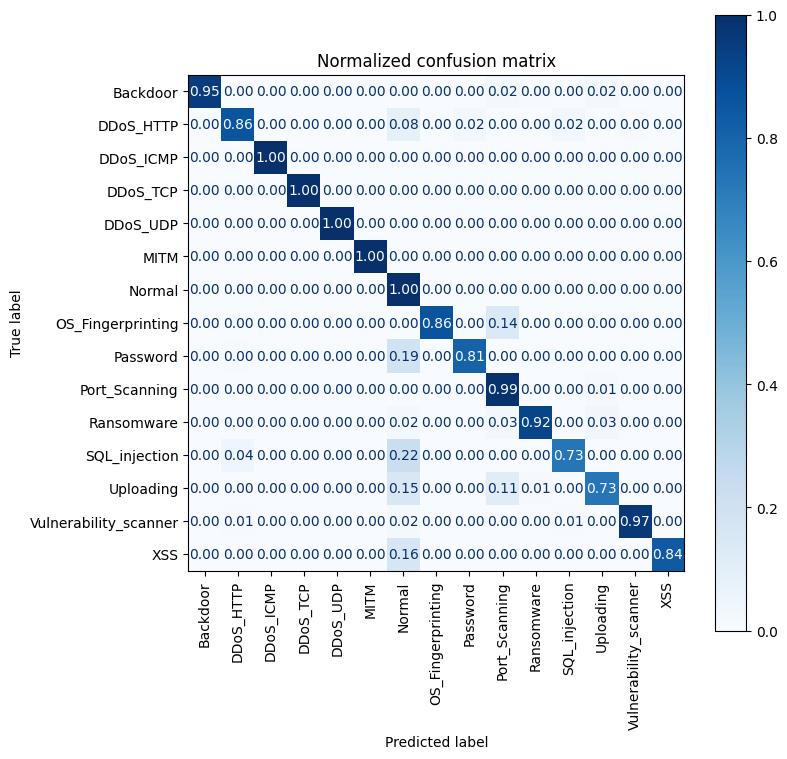

prediction time DecisionTreeClassifier+RandomForestClassifier: 0.0731813907623291


In [45]:
# _, y_class_2_test = get_data('2_class', 'test')
# X_test, y_class_15_test = get_data('15_class', 'test')

# # y_class_2_test = df_test[ids_common.target_label_2_class]
# # y_class_15_test = df_test[ids_common.target_label_15_class]

# # X_test = df_test.drop([ids_common.target_label_2_class, 
# #                 ids_common.target_label_15_class], 
# #                 axis=1, inplace=False)

X_test, y_test = ids_common.make_15_class(ddf_test)

detector = class_2_dt
classifier = class_14_rf

t_prediction = 0
t = time.time()
y_class_2_predict = detector.predict(X_test)
t_prediction += time.time()-t


ds_class_14 = ddf_test[y_class_2_predict==1]
X_class_14 = ds_class_14.drop(
                [ids_common.target_label_2_class, 
                ids_common.target_label_15_class], 
                axis=1, inplace=False)

t = time.time()
y_class_14_predict = classifier.predict(X_class_14)
t_prediction += time.time()-t

y_class_15_predict = pd.Series(y_class_2_predict, index=X_test.index.copy())
y_class_15_predict = y_class_15_predict.map(lambda x: 'Normal' if x==0 else 'Attack')
y_class_15_predict.loc[X_class_14.index] = le_14.inverse_transform(y_class_14_predict)

# print('DETECTION:')
# print(classification_report(y_class_2_test, y_class_2_predict))
# ids_common.plot_cm(y_class_2_test, y_class_2_predict)

print('CLASSIFICATION:')
print(classification_report(y_test, y_class_15_predict))
ids_common.plot_cm(y_test, y_class_15_predict)

print(f'prediction time {detector.__class__.__name__}+{classifier.__class__.__name__}: {t_prediction}')


In [27]:
# 10%
# prediction time RandomForestClassifier: 0.35144472122192383
# prediction time XGBClassifier: 0.09190726280212402
# prediction time DecisionTreeClassifier+RandomForestClassifier: 0.05083870887756348
# prediction time DecisionTreeClassifier+XGBClassifier: 0.016942501068115234

In [28]:
X_test, y_test = ids_common.make_15_class(ddf)

In [31]:
def measure_time(x_test, cls):
    class_time = []
    class_predicts = []
    for _, row in x_test.iterrows():
        t = time.time()
        # print(row)
        # class_15_xgb_predicts.append(class_15_xgb_xgb.predict(pd.DataFrame(row).T))
        class_predicts.append(cls.predict(row.to_numpy().reshape(1, -1)))

        class_time.append(time.time() - t)
    return class_time, class_predicts

def measure_time_cascade(x_test, detector, cls):
    class_casdade_time = []
    class_cascade_predicts = []
    for index, row in x_test.iterrows():
        t = time.time()
        record = row.to_numpy().reshape(1, -1)
        detection = detector.predict(record)

        if detection == 1:
            class_cascade_predicts.append(cls.predict(record))
        else:
            class_cascade_predicts.append(detection)
        
        class_casdade_time.append(time.time() - t)

    return class_casdade_time, class_cascade_predicts


In [35]:
# import pickle as pkl


# models = {
#     'class_15_xgb': class_15_xgb,
#     'class_15_rf': class_15_rf,
#     'class_2_dt': class_2_dt,
#     'class_14_xgb': class_14_xgb,
#     'class_14_rf': class_14_rf
# }

# pkl.dump(models, open('models.pkl', 'wb'))

In [36]:
# models = pkl.load(open('models.pkl', 'rb'))

In [46]:
class_15_xgb_time, class_15_xgb_predicts = measure_time(X_test, class_15_xgb)

class_15_rf_time, class_15_rf_predicts = measure_time(X_test, class_15_rf)

class_casdade_dt_rf_time, class_cascade_dt_rf_predicts = measure_time_cascade(X_test, class_2_dt, class_14_rf)

class_casdade_dt_xgb_time , class_cascade_dt_xgb_predicts = measure_time_cascade(X_test, class_2_dt, class_14_xgb)

In [33]:
def stats(tt):
    print(f'   min: {np.min(tt):0.5f}')
    print(f'   max: {np.max(tt):0.5f}')
    print(f'  mean: {np.mean(tt):0.5f}')
    # print(f'median: {np.median(tt):0.5f}')
    # print(f'   std: {np.std(tt):0.5f}')
    print(f' total: {np.sum(tt):0.5f}')

In [34]:
print('Classification 15 dt+rf:')
stats(class_casdade_dt_rf_time)
print('-'*80)

print('Classification 15 dt+rf:')
stats(class_casdade_dt_xgb_time)
print('-'*80)

print('Classification rf:')
stats(class_15_rf_time)
print('-'*80)

print('Classification xgb:')
stats(class_15_xgb_time)

print('-'*80)

Classification 15 dt+rf:
   min: 0.00000
   max: 0.00403
  mean: 0.00004
median: 0.00000
   std: 0.00020
 total: 0.92805
--------------------------------------------------------------------------------
Classification 15 dt+rf:
   min: 0.00000
   max: 0.00154
  mean: 0.00004
median: 0.00000
   std: 0.00020
 total: 1.00093
--------------------------------------------------------------------------------
Classification rf:
   min: 0.00000
   max: 0.00314
  mean: 0.00043
median: 0.00000
   std: 0.00052
 total: 10.40627
--------------------------------------------------------------------------------
Classification xgb:
   min: 0.00194
   max: 0.07356
  mean: 0.00316
median: 0.00300
   std: 0.00065
 total: 76.02802
--------------------------------------------------------------------------------


In [92]:
# X_test, _ = get_data('15_class', 'test')

class_15_xgb_time = []
class_15_xgb_predicts = []
for index, row in X_test.iterrows():
    t = time.time()
    # print(row)
    # class_15_xgb_predicts.append(class_15_xgb_xgb.predict(pd.DataFrame(row).T))
    class_15_xgb_predicts.append(class_15_xgb.predict(row.to_numpy().reshape(1, -1)))

    class_15_xgb_time.append(time.time() - t)

    # print(class_15_predicts, class_15_time)

In [93]:
# X_test, _ = get_data('15_class', 'test')

class_15_rf_time = []
class_15_rf_predicts = []
for index, row in X_test.iterrows():
    t = time.time()
    # print(row)
    # class_15_rf_predicts.append(class_15_rf_rf.predict(pd.DataFrame(row).T))
    class_15_rf_predicts.append(class_15_rf.predict(row.to_numpy().reshape(1, -1)))

    class_15_rf_time.append(time.time() - t)

    # print(class_15_predicts, class_15_time)

In [94]:
# X_test, _ = get_data('15_class', 'test')

class_casdade_dt_rf_time = []
class_cascade_dt_rf_predicts = []
for index, row in X_test.iterrows():
    t = time.time()
    record = row.to_numpy().reshape(1, -1)
    detection = class_2_dt.predict(record)

    if detection == 1:
        class_cascade_dt_rf_predicts.append(class_14_rf.predict(record))
    else:
        class_cascade_dt_rf_predicts.append(detection)
    
    class_casdade_dt_rf_time.append(time.time() - t)

print(class_casdade_dt_rf_time[:10])

[0.0, 0.0, 0.0015647411346435547, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [95]:
# X_test, _ = get_data('15_class', 'test')

class_casdade_dt_xgb_time = []
class_cascade_dt_xgb_predicts = []
for index, row in X_test.iterrows():
    t = time.time()
    record = row.to_numpy().reshape(1, -1)
    detection = class_2_dt.predict(record)

    if detection == 1:
        class_cascade_dt_xgb_predicts.append(class_14_xgb.predict(record))
    else:
        class_cascade_dt_xgb_predicts.append(detection)
    
    class_casdade_dt_xgb_time.append(time.time() - t)

print(class_casdade_dt_xgb_time[:10])

[0.005013227462768555, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [96]:
def stats(tt):
    print(f'   min: {np.min(tt):0.5f}')
    print(f'   max: {np.max(tt):0.5f}')
    print(f'  mean: {np.mean(tt):0.5f}')
    print(f'median: {np.median(tt):0.5f}')
    print(f'   std: {np.std(tt):0.5f}')
    print(f' total: {np.sum(tt):0.5f}')

In [97]:
print('Classification 15 dt+rf:')
stats(class_casdade_dt_rf_time)
print('-'*80)

print('Classification 15 dt+rf:')
stats(class_casdade_dt_xgb_time)
print('-'*80)

print('Classification rf:')
stats(class_15_rf_time)
print('-'*80)

print('Classification xgb:')
stats(class_15_xgb_time)

print('-'*80)

# print('Classification dummy:')
# stats(dummy_time)

Classification 15 dt+rf:
   min: 0.00000
   max: 0.00415
  mean: 0.00004
median: 0.00000
   std: 0.00020
 total: 0.99137
--------------------------------------------------------------------------------
Classification 15 dt+rf:
   min: 0.00000
   max: 0.00501
  mean: 0.00004
median: 0.00000
   std: 0.00021
 total: 1.03089
--------------------------------------------------------------------------------
Classification rf:
   min: 0.00197
   max: 0.08997
  mean: 0.00325
median: 0.00300
   std: 0.00078
 total: 78.23254
--------------------------------------------------------------------------------
Classification xgb:
   min: 0.00000
   max: 0.00171
  mean: 0.00044
median: 0.00000
   std: 0.00050
 total: 10.65108
--------------------------------------------------------------------------------


In [98]:
363/50

7.26

In [99]:
106/17

6.235294117647059